In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(here)
library(furrr)
library(cowplot)
library(glue)
library(lemon)
library(rtracklayer)
library(scales)
})

devtools::load_all(".")

plan(multiprocess, workers = 10)

Loading ychr


## Read coverage at each capture position

In [2]:
regions_cov <- function(ind, capture) {
    df <- get_coverage(here(paste0("data/coord/capture_", capture, ".bed")),
                       here(paste0("data/bam/", capture, "_", ind, ".bam"))) %>% as.data.frame
    cutoff <- quantile(df$coverage, 0.98)
    
    name <- fix_name(ind)
    
    cat(glue("{ind}\n98% coverage quantile: {cutoff}\n\n"))
    
    select(df, start, end, coverage) %>%
        filter(coverage <= cutoff) %>%
        mutate(name = name)
}

In [3]:
den4 <- regions_cov("den4", "full")

den4
98% coverage quantile: 5


In [4]:
den8 <- regions_cov("den8", "full")

den8
98% coverage quantile: 10


In [5]:
spy1 <- regions_cov("spy1", "full")

spy1
98% coverage quantile: 4


In [6]:
mez2 <- regions_cov("mez2", "full")

mez2
98% coverage quantile: 30


In [7]:
elsidron1 <- regions_cov("elsidron1", "exome")

elsidron1
98% coverage quantile: 12


In [8]:
elsidron2 <- regions_cov("elsidron2", "lippold")

elsidron2
98% coverage quantile: 21


In [9]:
subsamples <-
    list.files(here("data/bam"), "full_mez2_dp*.*bam$") %>%
    str_replace_all("full_|.bam", "") %>%
    future_map_dfr(~ regions_cov(.x, "full"))

mez2_dp1
98% coverage quantile: 4
mez2_dp10
98% coverage quantile: 21
mez2_dp2
98% coverage quantile: 6
mez2_dp3
98% coverage quantile: 8
mez2_dp4
98% coverage quantile: 10
mez2_dp5
98% coverage quantile: 12
mez2_dp6
98% coverage quantile: 14
mez2_dp7
98% coverage quantile: 16
mez2_dp8
98% coverage quantile: 18
mez2_dp9
98% coverage quantile: 19


In [10]:
shotgun <-
    list.files(here("data/bam"), "full_*shotgun*.*bam$") %>%
    str_replace_all("full_|.bam", "") %>%
    future_map_dfr(~ regions_cov(.x, "full"))

shotgun_mez2
98% coverage quantile: 3
shotgun_spy1
98% coverage quantile: 3


In [11]:
modern <-
    list.files(here("data/bam"), "full_[uaS].*bam$") %>%
    str_replace_all("full_|.bam", "") %>%
    future_map_dfr(~ regions_cov(.x, "full"))

a00_1
98% coverage quantile: 18
a00_2
98% coverage quantile: 22
a00
98% coverage quantile: 35
S_BedouinB-1
98% coverage quantile: 33
S_Burmese-1
98% coverage quantile: 43
S_Dai-2
98% coverage quantile: 31
S_Dinka-1
98% coverage quantile: 43
S_Finnish-2
98% coverage quantile: 27
S_French-1
98% coverage quantile: 33
S_Gambian-1
98% coverage quantile: 31
S_Han-2
98% coverage quantile: 32
S_Ju_hoan_North-1
98% coverage quantile: 34
S_Karitiana-1
98% coverage quantile: 34
S_Mandenka-1
98% coverage quantile: 26
S_Mbuti-1
98% coverage quantile: 31
S_Papuan-2
98% coverage quantile: 35
S_Punjabi-1
98% coverage quantile: 27
S_Saami-2
98% coverage quantile: 34
S_Sardinian-1
98% coverage quantile: 29
S_Thai-1
98% coverage quantile: 38
S_Turkish-1
98% coverage quantile: 34
S_Yoruba-2
98% coverage quantile: 27
ustishim
98% coverage quantile: 33


In [12]:
cov_df <- bind_rows(den4, den8, spy1, mez2, elsidron1, elsidron2, modern, subsamples, shotgun)

In [13]:
saveRDS(cov_df, here("data/rds/cov_df.rds"))

## Plot coverage along the Y chromosome

In [14]:
avg_cov <- group_by(cov_df, start, end, name) %>% summarise(avg_cov = mean(coverage))

Read some annotations and target region coordinates:

In [15]:
ychr <- read_tsv(here("input/yregions.tsv"), col_names = c("start", "end", "class"), col_types = "iic")
ychr[ychr$class == "heterochromatic", ][3, "end"] <- 29.8e6
ychr <- filter(ychr, end < 30e6)

regions <- import.bed(here("data/coord/capture_full.bed")) %>% as.data.frame %>% select(start, end)

In [62]:
plot_cov <- function(df, ind) {
    df <- filter(df, name == ind)

    ggplot() +
        geom_rect(data = df, aes(xmin = start, xmax = end, ymin = 0, ymax = avg_cov)) +
        theme_classic() +
        theme(
            legend.position = "none",
            axis.title = element_blank(),
            axis.line = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank()
        ) +
        geom_segment(aes(x = 2.4e6, xend = 29.4e6, y = c(2, 10, 20), yend = c(2, 10, 20)), linetype = 2, size = 0.1) +
        geom_segment(aes(x = 2.4e6, xend = 29.4e6, y = 0, yend = 0), size = 0.1) +
        geom_text(aes(2.2e6, 5, label = ind), hjust = "right") +
        xlim(x = c(0, 30e6)) + ylim(0, 25) +
        geom_text(aes(29.5e6, c(3, 11, 21), label = c("2X", "10X", "20X")), size = 3, hjust = "left")
}

In [63]:
p_den4 <- plot_cov(avg_cov, "Denisova 4")
p_den8 <- plot_cov(avg_cov, "Denisova 8")
p_spy1 <- plot_cov(avg_cov, "Spy 94a")
p_mez2 <- plot_cov(avg_cov, "Mezmaiskaya 2")
p_elsidron <- plot_cov(avg_cov, "El Sidrón 1253")

p_regions <- ggplot(regions) +
    geom_rect(aes(xmin = start, xmax = end, ymin = 0, ymax = 1)) +
    theme_classic() +
    theme(
        legend.position = "none",
        axis.line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()
    ) +
    xlim(x = c(0, 30e6)) + ggtitle("   ")

p_ychr <- ychr %>% mutate(class = fct_relevel(class, "others", after = Inf)) %>%
    ggplot() +
    geom_rect(aes(xmin = start, xmax = end, ymin = 0.2, ymax = 1, fill = class)) +
    theme_classic() +
    theme(
        legend.position = "bottom",
        axis.title = element_blank(),
        axis.line.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
    ) +
    geom_segment(aes(y = 0.2, yend = 1, x = 40e3, xend = 40e3), size = 1/2) +
    geom_segment(aes(y = 0.2, yend = 0.2, x = 0, xend = 30e6), size = 1/2) +
    geom_segment(aes(y = 1, yend = 1, x = 0, xend = 30e6), size = 1/2) +
    ylim(0, 1) +
    scale_x_continuous(limits = c(0, 30e6), label = comma) +
    scale_fill_manual(name = "", values = c("#E69F00", "lightgray", "#CC79A7", "#0072B2", "#D55E00", "#009E73")) +
    coord_capped_cart(bottom = "both") +
    guides(fill = guide_legend(nrow = 1))

Warning message:
“Removed 3 rows containing missing values (geom_rect).”Warning message:
“Removed 3 rows containing missing values (geom_rect).”Warning message:
“Removed 3 rows containing missing values (geom_rect).”Warning message:
“Removed 3 rows containing missing values (geom_rect).”Warning message:
“Removed 3 rows containing missing values (geom_rect).”

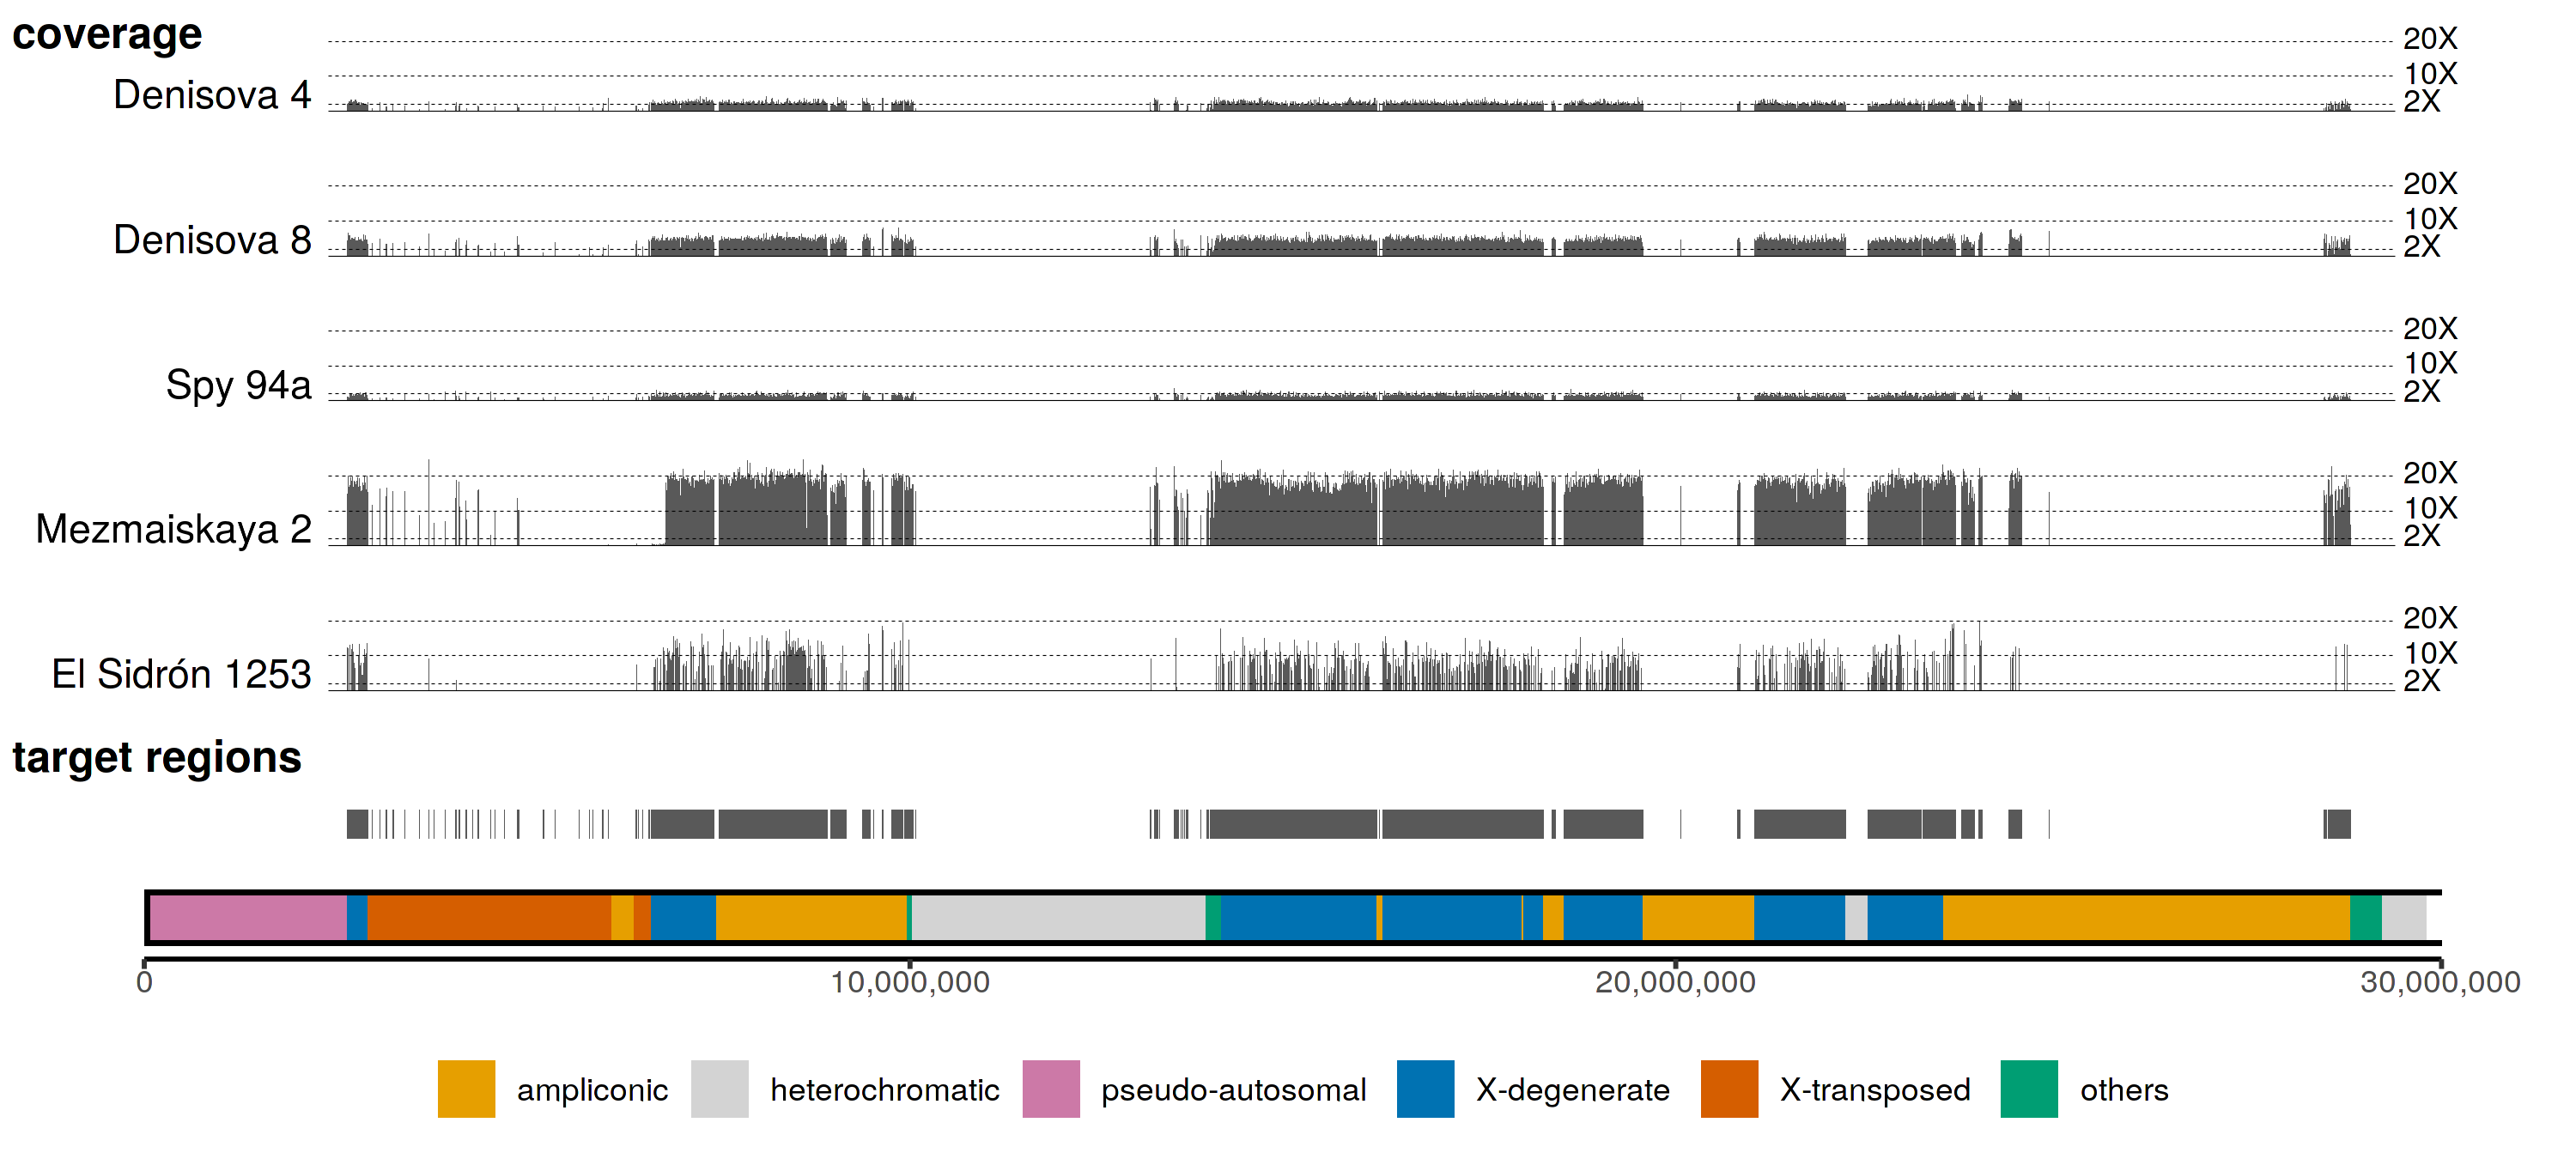

In [66]:
set_dim(10, 4.5)

plot_grid(p_den4, p_den8, p_spy1, p_mez2, p_elsidron, p_regions, p_ychr, ncol = 1,
          labels = c(" coverage", "", "", "", "", " target regions", ""), hjust = "left", label_size = 12,
          rel_heights = c(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2))

## Coverage statistics

In [19]:
our_archaic_df <- filter(cov_df,
                         name %in% c("Spy 94a", "Mezmaiskaya 2", "Denisova 4", "Denisova 8",
                                     "El Sidrón 1253"))

In [20]:
published_archaic_df <- filter(cov_df, str_detect(name, "(shotgun|118 kb)"))

In [25]:
modern_df <- filter(cov_df, str_detect(name, "S_") | name %in% c("Ust'-Ishim", "A00"))

In [22]:
our_archaic_df %>%
    group_by(name) %>%
    summarise(avg_cov = mean(coverage)) %>%
    arrange(avg_cov)

name,avg_cov
<chr>,<dbl>
Spy 94a,0.8253635
Denisova 4,1.3717758
Denisova 8,3.4819494
El Sidrón 1253,7.9165032
Mezmaiskaya 2,14.3491322


In [23]:
published_archaic_df %>%
    group_by(name) %>%
    summarise(avg_cov = mean(coverage)) %>%
    arrange(avg_cov)

name,avg_cov
<chr>,<dbl>
Spy 94a (shotgun),0.5053111
Mezmaiskaya 2 (shotgun),0.8248668
El Sidrón 1253 (118 kb),3.2121215


In [26]:
modern_df %>%
    group_by(name) %>%
    summarise(avg_cov = mean(coverage)) %>%
    arrange(avg_cov)

name,avg_cov
<chr>,<dbl>
S_Mandenka-1,16.33137
S_Yoruba-2,16.96166
S_Finnish-2,17.01557
S_Punjabi-1,17.14700
S_Sardinian-1,18.11902
S_Dai-2,19.81197
S_Gambian-1,20.12113
Ust'-Ishim,20.13725
S_Mbuti-1,20.33615


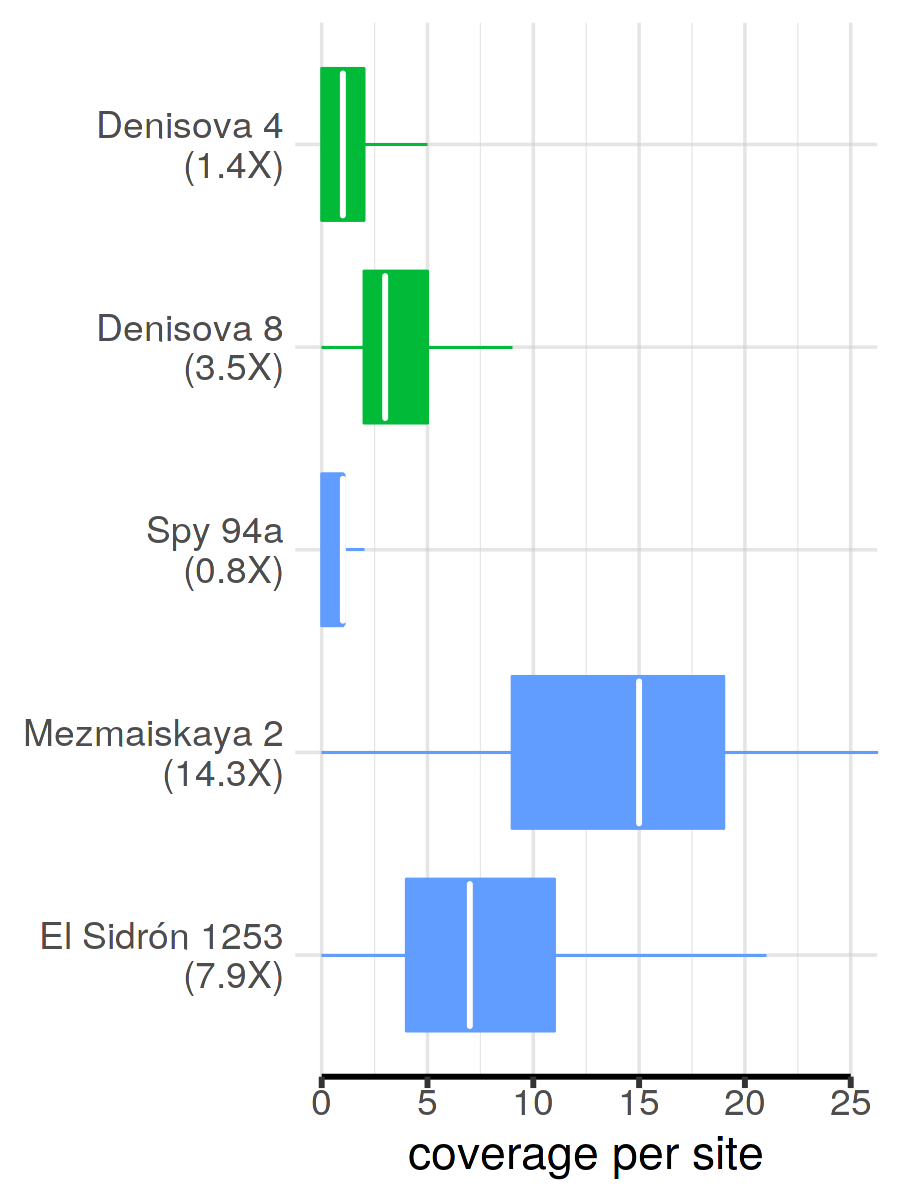

In [117]:
set_dim(3, 4)

our_archaic_df %>%
    mutate(name = fix_name(name, coverage = TRUE) %>% str_replace_all(" \\(", "\n\\(")) %>%
    filter(!str_detect(name, "118 kb")) %>%
assign_set %>%
ggplot(aes(fct_relevel(name, c("El Sidrón 1253\n(7.9X)", "Mezmaiskaya 2\n(14.3X)", "Spy 94a\n(0.8X)",
                               "Denisova 8\n(3.5X)", "Denisova 4\n(1.4X)")),
       coverage)) +
    geom_boxplot(size = 0.25, outlier.shape = NA, aes(fill = set, color = set)) +
    stat_summary(geom = "crossbar", width = 0.7, fatten = 0, color = "white",
                 fun.data = function(x){ return(c(y = median(x), ymin = median(x), ymax = median(x))) }) +
    theme_classic() +
    theme(
        legend.position = "none",
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank()
    ) +
    scale_fill_manual(values = c(hue_pal()(3)[c(2, 3)])) +
    scale_color_manual(values = c(hue_pal()(3)[c(2, 3)])) +
    background_grid(major = "xy", minor = "xy", size.major = 0.3, size.minor = 0.1,
                    color.major = rgb(0.8, 0.8, 0.8, alpha = 0.5),
                    color.minor = rgb(0.8, 0.8, 0.8, alpha = 0.5)) +
    ylab("coverage per site") +
    coord_capped_flip(ylim = c(0, 25), bottom = "both", left = "none")